# Game Prototype of Team Scotland 2
Felix Zaussinger, Martina Buck | 18.11.2020, 15:30

## Goals
1. give a first impression of what the game looks like

2. demonstrate simple game mechanisms

**Magic commands**

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**External imports**

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import configparser
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

**Figure properties**

In [3]:
sns.set_context("poster")
sns.set(rc={'figure.figsize': (8, 5)})
sns.set_style("ticks")

**Directory structure**

In [4]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "plots")
project_dir

'/Users/felix/ETH/code/gecm'

**Append project directory to PYTHONPATH via sys (!)**

Source: https://stackoverflow.com/questions/39299838/how-do-i-import-module-in-jupyter-notebook-directory-into-notebooks-in-lower-dir

In [5]:
if project_dir not in sys.path:
    sys.path.append(project_dir)

**Only now we can import our own code from src**

In [6]:
from src.gecm import model, vis, io, game, base, dicts
from src.gecm.field import Map
from src.gecm.dicts import (
        original_lulc_mapping,
        lulc_remapping,
        simplified_lulc_mapping,
        simplified_lulc_mapping_colors
    )

**Set game parameters**

In [7]:
# size of playing field in pixels
n_pixels = 40

# complexity of playing field (only granularity = 1 works for now)
granularity = 1

**Other definitions and imports which are needed**

In [8]:
# colormap
simplified_lulc_cm = ListedColormap(
    [simplified_lulc_mapping_colors[x] for x in simplified_lulc_mapping_colors.keys()]
)

# path to raster data file (must be a geotiff)
fpath_map = os.path.join(
    data_processed, "NFI_rasterized_{}_{}.tif".format(n_pixels, n_pixels)
)

**Establish connection to Google Drive documents**

In [9]:
# init config file parser. methods: config.getboolean, config.getint, ... .
config = configparser.ConfigParser()
fpath_cf = os.path.join(project_dir, 'config.ini')
config.read(fpath_cf)

['/Users/felix/ETH/code/gecm/config.ini']

**Show configuration file sections**

In [10]:
io.config_describe(config)


--- default ---
credentials: 'google_api_credentials.json'
scopes: https://www.googleapis.com/auth/spreadsheets.readonly

--- gdrive_spreadsheet_ids ---
spreadsheet_id_farmers: 1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc
spreadsheet_id_foresters: 1ir8WkfKpyEGkamASbd0pf9IDAE74M4Q1fsHYl4r9F34
spreadsheet_id_tourism: 1EA_mCM9Pp_URb_JavM-mMIqixTvZewSkGC2b-wDa1ns
spreadsheet_id_model: 1CVdDndGD1S8ab3D1KlXYcBcnjK8sBPl68Eth0KMgaEQ

--- gdrive_sheet_names ---
sheet_names_farmers: Farmer_1, Farmer_2
sheet_names_foresters: Forester_1, Forester_2
sheet_names_tourism: SSDA
sheet_names_model: model_parameters, model_calculations


**Parse management decisions** --> As a first example, read the farmer's decisions.

Parameter settings

In [11]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = [config.get(section="default", option="scopes")]

# <Your spreadsheet ID>
# SPREADSHEET_ID = config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_farmers")

# <Your worksheet names>
# SHEETS_STRING = config.get(section="gdrive_sheet_names", option="sheet_names_farmers")
# SHEETS = io.parse_list(config_string=SHEETS_STRING)

# API credentials
credentials_fpath = os.path.join(project_dir, 'google_api_credentials.json')

**Define the playing field**

load map

In [12]:
playing_field = Map(
    fpath=fpath_map,
    original_lulc_mapping=original_lulc_mapping,
    simplified_lulc_mapping=simplified_lulc_mapping,
    lulc_remapping=lulc_remapping,
    cmap=simplified_lulc_cm
)

**initialise playing field (crucial, else nothing works!)**

In [13]:
playing_field.initialise(granularity=1)

**sanity check on current round**

In [14]:
assert playing_field.current_round == 1

#### Parse model parameters and formulas

In [15]:
%reload_ext autoreload
model_settings_dict = io.parse_sheets(
        spreadsheet_id=config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_model"), 
        sheets=io.parse_list(config_string=config.get(section="gdrive_sheet_names", option="sheet_names_model")),
        credentials_fpath=credentials_fpath, 
        scopes=SCOPES,
        to_numeric=True
    )

model_parameters
model_calculations


#### Parametrise the conceptual model

In [16]:
%reload_ext autoreload
game_model = model.ConceptualModel(
    model_parameters=model_settings_dict["model_parameters"],
    model_calculations=model_settings_dict["model_calculations"]
)

In [17]:
game_model.model_parameters

,description,variable,value,unit,Source 1,Source 2,Comment
0,Farmland: sheep,income_farmland_sheep,30.000,pound/ha/yr,https://www.gov.scot/publications/farm-busines...,https://www.gov.scot/publications/total-income...,Southern Scotland seems to have good profitabi...
1,Farmland: cattle,income_farmland_cattle,100.000,pound/ha/yr,NaN,NaN,NaN
2,Commercial forest,income_forest_commercial,200.000,pound/ha/yr,https://www.isurv.com/info/390/features/11524/...,,Ella-Mona: wood from the Biosphere commercial ...
3,Native forest,income_forest_native,50.000,pound/ha/yr,from minor timber usage,,What shall we put in here? Carbon offsetting (...
4,Tourism,gdp_tourism,43.952,percentage (multiplier),https://www.gov.scot/publications/tourism-scot...,,percentage of GDP
5,GDP pro capita (Scotland),gdp_pc_scotland,29.600,pound/yr,https://www.ons.gov.uk/economy/grossdomesticpr...,NaN,NaN
6,Average Farm Income (Scotland),income_farm,39.000,pound/yr,NaN,NaN,NaN
7,Unemployment rate Scotland,unempl_rate_scotland,5.000,percentage of unemployment,GSA Socioecomomic Study,NaN,NaN
8,Unemployment rate Southern West,unempl_rate_scotland_west,5.000,percentage of unemployment,GSA Socioecomomic Study,,However in the Socioeconomic study was highlig...
9,Bankaccount Farmer 1,bank_account_farmer_1,10.000,pound,NaN,NaN,NaN


# Fancy game name

## First game instructions
 
- Landscape is an ever changing thing. But those changes don't always happen without conflicts. 
- In the following game, you will be part of a group of stakeholders. 
- You can take the role of being foresters, farmers or tourism association representatives.
- To start a new game and distribute all roles, fill in the numbers of players (3 to 6). --> only "number_of_players = 6" works so far!

In [18]:
number_of_players = 6
game.roles(number_of_players)

There are 6 roles for each player, Farmer 1 and 2, Forester 1 and 2 and Tourism association (SSDA) representatives 1 and 2. Please distribute each role among yourselves


- To play the game, every player fills out his decisions on what to do with his land on the google sheet for his role (maybe we could put here a link but then everyone has acces to everyones decisions...). A map of the area changes based on your decisions.

## Starting point

Now have a look at playing field.

You find yourselves in Scottland in the area of Galloway and Southern Ayrshire Biosphere. The government decided that more forest area in Scottland is needed to help combate climate change. At the same time, the people of Scottland need steady jobs with a decent pay. You find yourself either managing Farmland, Forest or tourism industry (SSDA) representative.

As a farmer, you can make money by selling agricultural products. As a forester, you can make money by selling timber. As a tourism industry (SSDA) representative, you represent the interests of the local tourism industry, which primarily consist of micro-businesses (less than 10 employees).

<AxesSubplot:xlabel='Percent of total area (%)'>

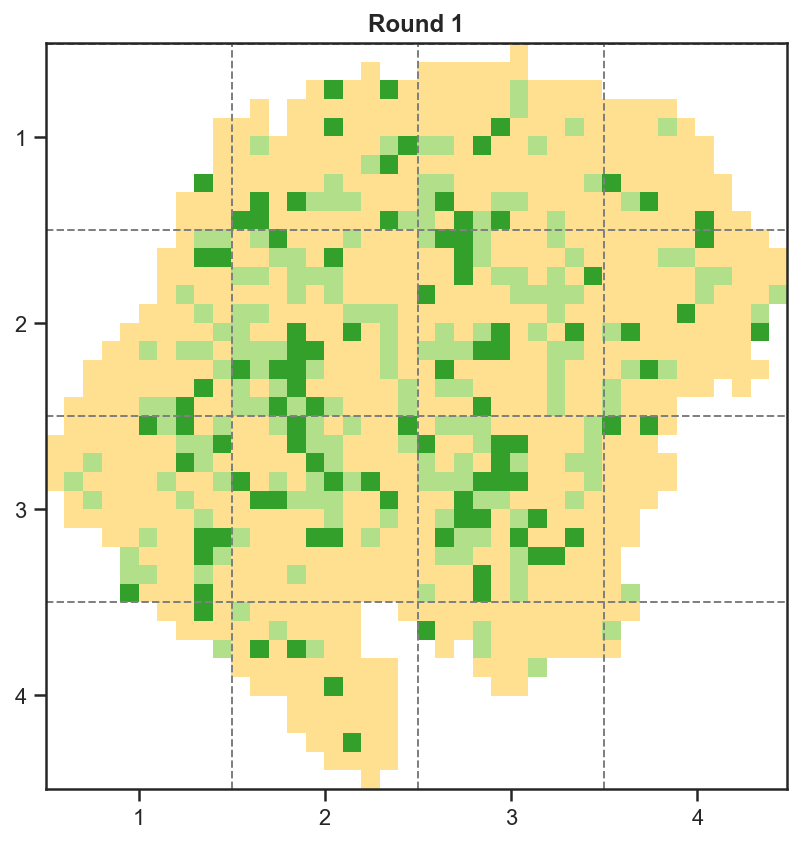

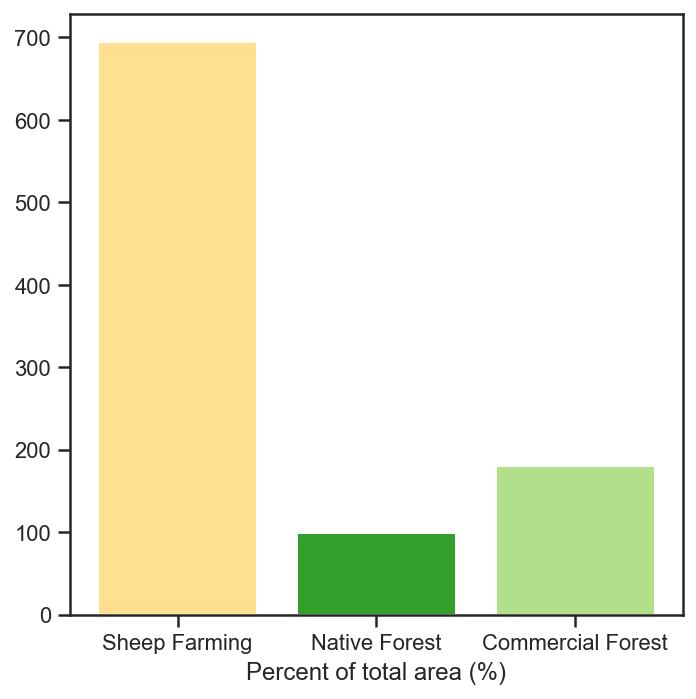

In [19]:
%reload_ext autoreload
playing_field.show(figure_size=(6,6))
playing_field.show_bar(figure_size=(5,5))

## Round 1

Please wait a moment while we are accessing your management decisions ...

In [20]:
%%time
dict_of_mgmt_decisions_dfs = {}

for stakeholder_group in ["farmers", "foresters", "tourism"]:
    dict_of_mgmt_decisions_dfs[stakeholder_group] = io.parse_mgmt_decisions(
        spreadsheet_id=config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_{}".format(stakeholder_group)), 
        sheets=io.parse_list(config_string=config.get(section="gdrive_sheet_names", option="sheet_names_{}".format(stakeholder_group))),
        credentials_fpath=credentials_fpath, 
        scopes=SCOPES, 
        unstack_data=False
    )

Farmer_1
Farmer_2
Forester_1
Forester_2
SSDA
CPU times: user 1.04 s, sys: 276 ms, total: 1.32 s
Wall time: 8.23 s


In [21]:
# combine
df_mgmt_decisions = pd.concat(dict_of_mgmt_decisions_dfs.values(), keys=dict_of_mgmt_decisions_dfs.keys())
df_mgmt_decisions.index.rename("stakeholder", level=0, inplace=True)
df_mgmt_decisions_long = df_mgmt_decisions.reset_index()
df_mgmt_decisions_long["id"] = df_mgmt_decisions_long.index.values

In [22]:
df_mgmt_decisions_long.head()

,stakeholder,round,player,Plot,Sheep,Cattle,Native Forest,Teamwork,Commercial Forest,SSDA,id
0,farmers,1,Farmer_1,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0
1,farmers,1,Farmer_2,NaN,0.0,0.0,0.0,NaN,NaN,NaN,1
2,farmers,2,Farmer_1,NaN,0.0,0.0,0.0,NaN,NaN,NaN,2
3,farmers,2,Farmer_2,NaN,0.0,0.0,0.0,NaN,NaN,NaN,3
4,farmers,3,Farmer_1,NaN,0.0,0.0,0.0,NaN,NaN,NaN,4


In [23]:
id_vars = ["stakeholder", "round", "player", "Plot", "Teamwork"]
value_vars = ["Sheep", "Cattle", "Native Forest", "Commercial Forest"]
df_mgmt_decisions_melted = df_mgmt_decisions_long.melt(id_vars=id_vars, value_vars=value_vars)
df_mgmt_decisions_melted.head()

,stakeholder,round,player,Plot,Teamwork,variable,value
0,farmers,1,Farmer_1,NaN,NaN,Sheep,0.0
1,farmers,1,Farmer_2,NaN,NaN,Sheep,0.0
2,farmers,2,Farmer_1,NaN,NaN,Sheep,0.0
3,farmers,2,Farmer_2,NaN,NaN,Sheep,0.0
4,farmers,3,Farmer_1,NaN,NaN,Sheep,0.0


https://seaborn.pydata.org/tutorial/relational.html: seaborn supports semantics of hue, size, and style

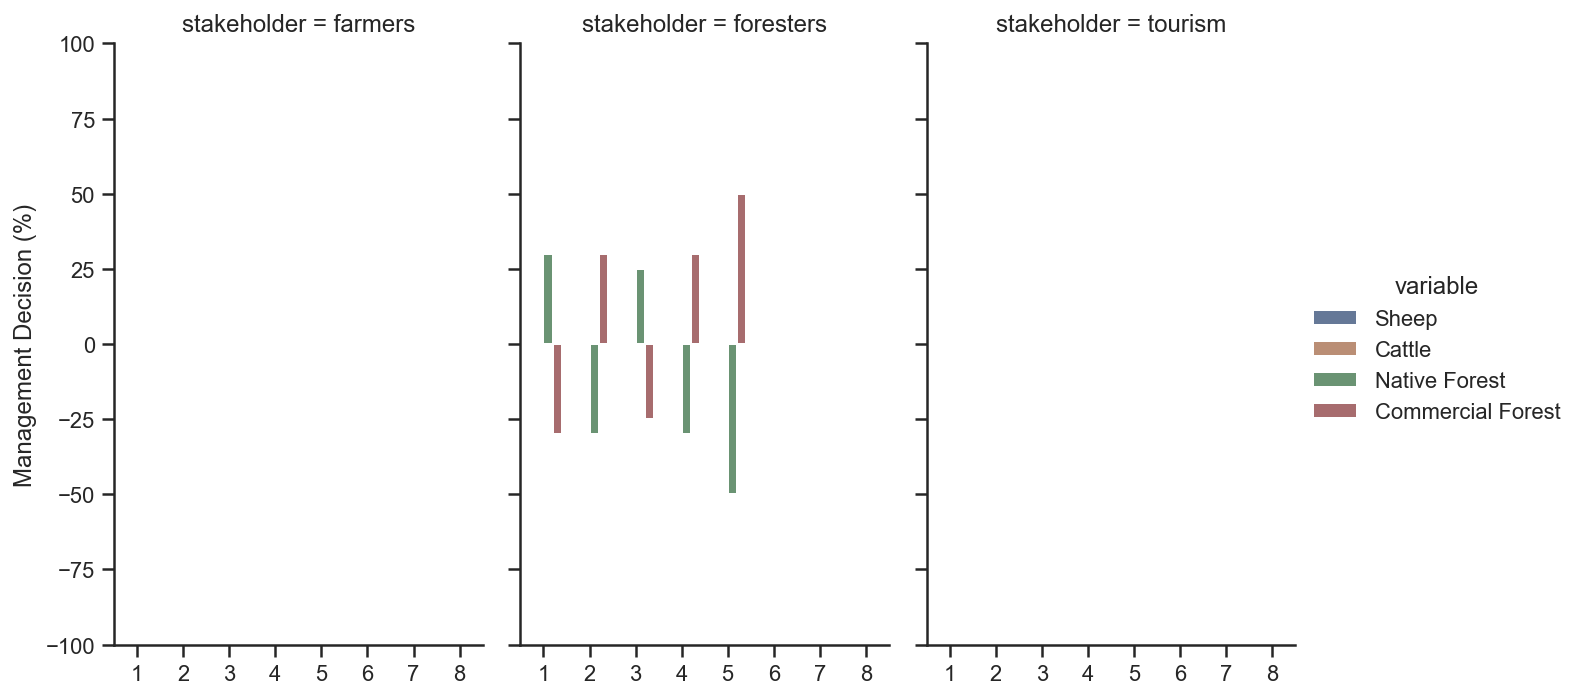

In [24]:
g = sns.catplot(x="round", y="value", hue="variable", col="stakeholder", kind="bar", data=df_mgmt_decisions_melted, saturation=.5, ci=None, aspect=.6)

(g.set_axis_labels("", "Management Decision (%)")
 #.set_xticklabels(["round", "round", "round"])
 #.set_titles("{col_name} {col_var}")
 .set(ylim=(-100, 100)).despine(left=False))

Done! Please wait a final moment while we are updating the playing field based on your management decisions.

**TODO [high]: update map based on conceptual model**

In [25]:
playing_field.simplified_lulc_mapping

{'Sheep Farming': 1,
 'Native Forest': 2,
 'Commercial Forest': 3,
 'Cattle Farming': 4}

In [26]:
playing_field.map_simplified

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=255,
  dtype=uint8)

In [27]:
%reload_ext autoreload
global_yield = model.calculate_yield(
    field=playing_field.map_simplified,
    lulc_mapping=playing_field.simplified_lulc_mapping,
    relative=False
)
list(playing_field.simplified_lulc_mapping.keys())

global_yield_remapped = dict(zip(playing_field.simplified_lulc_mapping.keys(), list(global_yield.values())))

df_global_yield_remapped = pd.DataFrame(global_yield_remapped, index=["yield"]).transpose()

<AxesSubplot:>

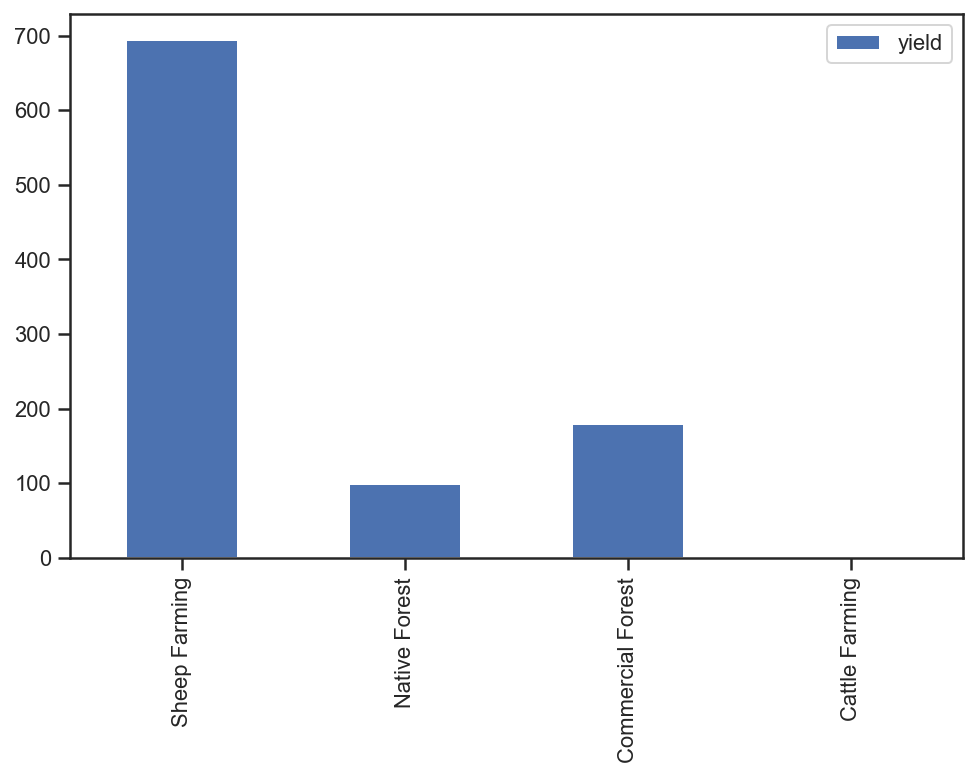

In [28]:
df_global_yield_remapped.plot.bar()

In [29]:
%reload_ext autoreload
game_model.bank_account_farmers1["round_1"] = 3000
game_model.bank_account_farmers1["round_2"] = 7000

Let's evaluate the impact of your first management decisions on the landscape ...

In [30]:
# TODO: display updated map and bar-charts with LULC changes

... and on regional GDP & employment:

In [31]:
# TODO: display the state of GDP and employment

## Round 2

## Round 3